# This notebook summarizes the results obtained after combining AI techniques to analyze tweets.
## The chosen techniques were selected from the following areas: Text Mining, Temporal Graph, and Time Series.
### Paper: Quantifying Temporal Novelty in Social Networks Using Time-Varying Graphs and Concept Drift Detection
### Link: https://link.springer.com/chapter/10.1007/978-3-030-61380-8_44

In [1]:
import numpy as np # array and vector manipulation
import pandas as pd # data manipulation
import os # using system calls
from nltk.corpus import stopwords
import datetime 
from collections import Counter
import matplotlib.pyplot as plt
import re
import nltk
#nltk.download('wordnet')
#nltk.download('punkt')
#nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from joblib import Parallel, delayed
import multiprocessing as mp
#
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


from stop_words import get_stop_words
from nltk.corpus import stopwords

from sklearn import preprocessing

In [2]:
os.getcwd()

'/home/rios/programming/CURSO-SENAI'

In [3]:
data = pd.read_csv('preprocessamento/dados/data_trump.csv')
data

Tweet                 Date
0     ....The Prime Minister was able to save a grea...  08-20-2019 23:51:53
1     Denmark is a very special country with incredi...  08-20-2019 23:51:52
2     CONGRATULATIONS @EricTrump and @LaraLeaTrump o...  08-20-2019 20:00:41
3                               https://t.co/WyGbgUGEhJ  08-20-2019 18:13:51
4     RT @FullMeasureNews: Sunday on Full Measure: C...  08-20-2019 18:12:59
...                                                 ...                  ...
5245  Fake News of which there is soooo much (this t...  08-21-2018 11:10:49
5246  Even James Clapper has admonished John Brennan...  08-21-2018 10:55:03
5247  A Blue Wave means Crime and Open Borders. A Re...  08-21-2018 10:38:19
5248  I am hearing so many great things about the Re...  08-21-2018 03:53:49
5249  Will be going to the Great State of West Virgi...  08-21-2018 03:40:49

[5250 rows x 2 columns]

In [4]:
data.shape

(5250, 2)

In [5]:
data.iloc[1,1]

'08-20-2019 23:51:52'

In [6]:
d = datetime.datetime.strptime(data.iloc[1,1], '%m-%d-%Y %H:%M:%S')
print(f"{d.date()}")

2019-08-20


In [7]:
data['Date'] = pd.to_datetime(data['Date'])
data

Tweet                Date
0     ....The Prime Minister was able to save a grea... 2019-08-20 23:51:53
1     Denmark is a very special country with incredi... 2019-08-20 23:51:52
2     CONGRATULATIONS @EricTrump and @LaraLeaTrump o... 2019-08-20 20:00:41
3                               https://t.co/WyGbgUGEhJ 2019-08-20 18:13:51
4     RT @FullMeasureNews: Sunday on Full Measure: C... 2019-08-20 18:12:59
...                                                 ...                 ...
5245  Fake News of which there is soooo much (this t... 2018-08-21 11:10:49
5246  Even James Clapper has admonished John Brennan... 2018-08-21 10:55:03
5247  A Blue Wave means Crime and Open Borders. A Re... 2018-08-21 10:38:19
5248  I am hearing so many great things about the Re... 2018-08-21 03:53:49
5249  Will be going to the Great State of West Virgi... 2018-08-21 03:40:49

[5250 rows x 2 columns]

<BarContainer object of 24 artists>

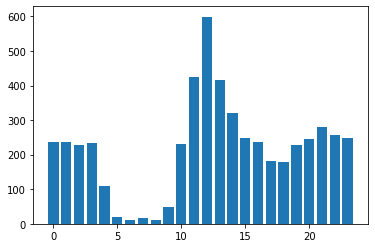

In [8]:
hour_freq = Counter((data["Date"].dt.hour))
plt.bar(hour_freq.keys(), hour_freq.values())

In [9]:
subset = data.iloc[0:10,0]
subset

0    ....The Prime Minister was able to save a grea...
1    Denmark is a very special country with incredi...
2    CONGRATULATIONS @EricTrump and @LaraLeaTrump o...
3                              https://t.co/WyGbgUGEhJ
4    RT @FullMeasureNews: Sunday on Full Measure: C...
5    Sorry I don’t buy Rep. Tlaib’s tears. I have w...
6    The LameStream Media is far beyond Fake News t...
7                   Thank you! https://t.co/LANNJ7IfEl
8    RT @GOPChairwoman: .@realDonaldTrump puts Amer...
9    RT @GOPChairwoman: Since @realDonaldTrump was ...
Name: Tweet, dtype: object

In [14]:
def run_stopwords(t):
    t = re.sub('\s+(a|an|and|the|of|in|is|are|i|you|me|she|he|they|so|for|wa)(\s+)', '\2', t)
    word_list = nltk.word_tokenize(re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", t))
    words = set(nltk.corpus.words.words())
    stop_words = set(stopwords.words('english'))

    word_list = [w for w in word_list if w in words and w.isalpha()]
    filtered_sentence = ' '.join([w for w in word_list if not w in stop_words])
    return (filtered_sentence)
    


def tweets_to_mat(t):
    # convert to lowercase
    t = t.str.lower()
    
    # clean dataset
    regex = (r"(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}"
             r"www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))"
             r"[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})|\b(R|r)(T|t)\b|\b[0-9]+\b"
             r"|\-\-")
    clean = np.array([re.sub(regex, "", xi, flags=re.MULTILINE).strip() for xi in t])
    
    # lemmatizer
    lemmatizer = WordNetLemmatizer()

    word_list = np.array([nltk.word_tokenize(x) for x in clean])
    
    lemmatized_output = ([' '.join([lemmatizer.lemmatize(w) for w in ws]) for ws in word_list])
     
    # resp = Parallel(n_jobs=mp.cpu_count())(delayed(run_stopwords)(text) for text in lemmatized_output)
    resp = Parallel(n_jobs=3)(delayed(run_stopwords)(text) for text in lemmatized_output)

    vec = CountVectorizer() #freq
    #vec = TfidfVectorizer() #tfidf
    X = vec.fit_transform(resp)
    df = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())
    return (df)
    

In [11]:
data['Date'] = data['Date'].dt.hour
data

Tweet  Date
0     ....The Prime Minister was able to save a grea...    23
1     Denmark is a very special country with incredi...    23
2     CONGRATULATIONS @EricTrump and @LaraLeaTrump o...    20
3                               https://t.co/WyGbgUGEhJ    18
4     RT @FullMeasureNews: Sunday on Full Measure: C...    18
...                                                 ...   ...
5245  Fake News of which there is soooo much (this t...    11
5246  Even James Clapper has admonished John Brennan...    10
5247  A Blue Wave means Crime and Open Borders. A Re...    10
5248  I am hearing so many great things about the Re...     3
5249  Will be going to the Great State of West Virgi...     3

[5250 rows x 2 columns]

In [12]:
### Full
tw11 = data.loc[np.where(data["Date"] == 11)]
tw12 = data.loc[np.where(data["Date"] == 12)]

In [15]:
mtw11 = tweets_to_mat(tw11['Tweet'])
mtw12 = tweets_to_mat(tw12['Tweet'])

/usr/lib/python3/dist-packages/ipykernel_launcher.py:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [16]:
### uncomment for testing (10 terms)
cmtw11 = mtw11.iloc[:, np.argsort(np.sum(mtw11.values, axis=0))[::-1][0:10]]
cmtw12 = mtw12.iloc[:, np.argsort(np.sum(mtw12.values, axis=0))[::-1][0:10]]
### full version
#cmtw11 = mtw11.iloc[:,np.argsort(mtw11.sum(axis=0))[::-1]]
#cmtw12 = mtw12.iloc[:,np.argsort(mtw12.sum(axis=0))[::-1]]

In [17]:
cmtw11[cmtw11 > 1] = 1 
cmtw12[cmtw12 > 1] = 1 

/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/rios/.local/lib/python3.6/site-packages/pandas/core/frame.py:3515: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(-key, value, inplace=True)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata

In [19]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity(np.array(mtw11.iloc[10,:]).reshape(1, -1), np.array(mtw11.iloc[50,:]).reshape(1, -1))

array([[0.]])

In [21]:
cmtw11 = cmtw11.T.dot(cmtw11)
np.fill_diagonal(cmtw11.values, 0)
cmtw11.iloc[:,:] = np.triu(cmtw11)

cmtw12 = cmtw12.T.dot(cmtw12)
np.fill_diagonal(cmtw12.values, 0)
cmtw12.iloc[:,:] = np.triu(cmtw12)

In [22]:
cmtw11

ha  great  people  trump  democrat  president  get  new  news  \
ha          0      7       6      5         0          3    3    4     7   
great       0      0       8      1         2          4    0    3     1   
people      0      0       0      5         3          1    2    2     5   
trump       0      0       0      0         4          6    3    4     2   
democrat    0      0       0      0         0          3    2    0     0   
president   0      0       0      0         0          0    2    2     1   
get         0      0       0      0         0          0    0    1     5   
new         0      0       0      0         0          0    0    0     2   
news        0      0       0      0         0          0    0    0     0   
never       0      0       0      0         0          0    0    0     0   

           never  
ha             4  
great          3  
people         6  
trump          1  
democrat       4  
president      2  
get            1  
new            2  
news           3  
never          0

In [23]:
np.argsort(np.sum(cmtw12.values, axis=0))[::-1]

#cmtw12.values

array([8, 9, 7, 6, 2, 4, 5, 3, 1, 0])

In [24]:
import networkx as net

day1 = net.Graph()
day1.add_nodes_from(np.array(cmtw11.columns, cmtw12.columns))

edg = list()

for i in np.arange(len(cmtw11.columns)):
    for j in np.arange(start=i+1, stop=len(cmtw11.columns)):
        if cmtw11.iloc[i,j] > 0:
            edg.append((cmtw11.columns[i], cmtw11.columns[j], cmtw11.iloc[i,j]))

day1.add_weighted_edges_from(edg)


In [25]:
day2= net.Graph()
day2.add_nodes_from(np.array(cmtw11.columns, cmtw12.columns))

edg = list()

for i in np.arange(len(cmtw12.columns)):
    for j in np.arange(start=i+1, stop=len(cmtw12.columns)):
        if cmtw12.iloc[i,j] > 0:
            edg.append((cmtw12.columns[i], cmtw12.columns[j], cmtw12.iloc[i,j]))

day2.add_weighted_edges_from(edg)

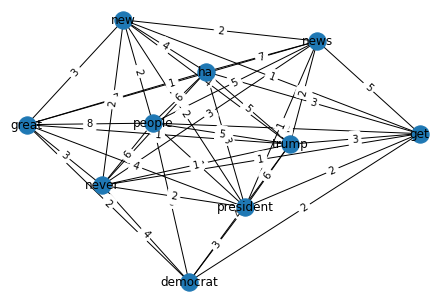

In [26]:
import pylab

pos=net.spring_layout(day1)

pylab.figure()
net.draw(day1,pos, with_labels=True)
edge_labels=dict([((u,v,),d['weight']) for u,v,d in day1.edges(data=True)])
net.draw_networkx_edge_labels(day1,pos,edge_labels=edge_labels)

pylab.show()

## Running the full execution
### - Time Series production

In [28]:
def cal_dist(m1,m2):
    return (np.sum(np.sqrt(np.abs(m1.values - m2.values))))

In [29]:
ts_distances = []
hours = np.sort(data["Date"].unique())

for hour in np.arange(len(hours)-1):
    print(f"Comparing hours {hour} and {hour+1}")
    tw1 = data.loc[np.where(data["Date"] == hour)]
    tw2 = data.loc[np.where(data["Date"] == (hour+1))]
    
    mtw1 = tweets_to_mat(tw1['Tweet'])
    mtw2 = tweets_to_mat(tw2['Tweet'])
    
    # which columns are in 2 but not in 1?
    diff = mtw2.columns[(np.where(~np.in1d(mtw2.columns, mtw1.columns)))]
    tmp  = pd.DataFrame(np.zeros((mtw1.shape[0], len(diff))))
    tmp.columns = diff
    mtw1 = pd.concat([mtw1, tmp], axis=1)
    
    # which columns are in 2 but not in 1?
    diff = mtw1.columns[(np.where(~np.in1d(mtw1.columns, mtw2.columns)))]
    tmp  = pd.DataFrame(np.zeros((mtw2.shape[0], len(diff))))
    tmp.columns = diff
    mtw2 = pd.concat([mtw2, tmp], axis=1)
    
    cmtw1 = mtw1.iloc[:,np.argsort(mtw1.sum(axis=0))[::-1]]
    cmtw2 = mtw2.iloc[:,np.argsort(mtw2.sum(axis=0))[::-1]]
    
    cmtw1 = cmtw1.T.dot(cmtw1)
    np.fill_diagonal(cmtw1.values, 0)
    cmtw1.iloc[:,:] = np.triu(cmtw1)

    cmtw2 = cmtw2.T.dot(cmtw2)
    np.fill_diagonal(cmtw2.values, 0)
    cmtw2.iloc[:,:] = np.triu(cmtw2)
    
    
    
    # organize the columns in both DF
    cmtw1.reindex(sorted(cmtw1.columns), axis=1)
    cmtw2.reindex(sorted(cmtw2.columns), axis=1)
    
    # now compare them
    ts_distances.append(cal_dist(cmtw1, cmtw2))
    

Comparing hours 0 and 1


/usr/lib/python3/dist-packages/ipykernel_launcher.py:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Comparing hours 1 and 2
Comparing hours 2 and 3
Comparing hours 3 and 4
Comparing hours 4 and 5
Comparing hours 5 and 6
Comparing hours 6 and 7
Comparing hours 7 and 8
Comparing hours 8 and 9
Comparing hours 9 and 10
Comparing hours 10 and 11
Comparing hours 11 and 12
Comparing hours 12 and 13
Comparing hours 13 and 14
Comparing hours 14 and 15
Comparing hours 15 and 16
Comparing hours 16 and 17
Comparing hours 17 and 18
Comparing hours 18 and 19
Comparing hours 19 and 20
Comparing hours 20 and 21
Comparing hours 21 and 22
Comparing hours 22 and 23


In [ ]:
norm_ts = preprocessing.normalize([ts_distances])
with plt.style.context("ggplot"):
    plt.plot(np.arange(norm_ts.shape[1]),
             norm_ts[0],'r')
    plt.axhline(y=np.mean(norm_ts[0])+np.std(norm_ts[0]), color='b', linestyle='-')
    plt.axhline(y=np.mean(norm_ts[0])-np.std(norm_ts[0]), color='b', linestyle='-')
    plt.xlabel('Time (secs)')
    
    plt.grid(True)
    plt.show()
    